<a href="https://colab.research.google.com/github/comojin1994/Deep_Learning_Study/blob/master/Kaggle/Global_Wheat_Detection/Global_Wheat_Detection_FasterRCNN_resnet50fpn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd ./drive/My\ Drive/Kaggle/Global_Wheat_Detection/input/global-wheat-detection

/content/drive/My Drive/Deep_learning/Kaggle/Global_Wheat_Detection/input/global-wheat-detection


In [0]:
# !unzip global-wheat-detection.zip

In [0]:
%cd ..

/content/drive/My Drive/Deep_learning/Kaggle/Global_Wheat_Detection/input


In [0]:
%cd ..

/content/drive/My Drive/Deep_learning/Kaggle/Global_Wheat_Detection


In [0]:
%cd output/

/content/drive/My Drive/Deep_learning/Kaggle/Global_Wheat_Detection/output


In [0]:
!ls

customtrained_fasterrcnn_resnet50_fpn.pth
Global_Wheat_Detection_FasterRCNN_resnet50fpn.ipynb


In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image

import cv2

import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms

import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import random

In [0]:
os.listdir('../input/global-wheat-detection')

train_dir = '../input/global-wheat-detection/train'
test_dir = '../input/global-wheat-detection/test'

df_train = pd.read_csv('../input/global-wheat-detection/train.csv')

In [0]:
print(df_train.head())
print(df_train.shape)

    image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1
(147793, 5)


In [0]:
print(len(df_train['image_id'].unique()))
print((df_train.shape[0]) / len(df_train['image_id'].unique()))

3373
43.8164838422769


In [0]:
print('Image_id v/s # of bounding boxes')
print(df_train['image_id'].value_counts())

Image_id v/s # of bounding boxes
35b935b6c    116
f1794c924    108
f79336a8e    104
134d4a01c    101
4cf91995d     97
            ... 
22f341965      1
86296fc32      1
ce4124be0      1
76595919e      1
6a62af644      1
Name: image_id, Length: 3373, dtype: int64


In [0]:
df_train[df_train['image_id']=='86296fc32']

,image_id,width,height,bbox,source
121449,86296fc32,1024,1024,"[701.0, 284.0, 64.0, 228.0]",arvalis_3


In [0]:
print('Height')
print(df_train['height'].value_counts())
print('Width')
print(df_train['width'].value_counts())

Height
1024    147793
Name: height, dtype: int64
Width
1024    147793
Name: width, dtype: int64


In [0]:
list_image_ids_df = list(df_train['image_id'].unique())
list_image_ids_dir = os.listdir('../input/global-wheat-detection/train/')

In [0]:
len(list_image_ids_dir) - len(list_image_ids_df)

49

In [0]:
for col in df_train.columns:
    if sum(df_train[col].isnull()) == 1:
        print(col + ' has null values')
    else:
        print(col + ' no null values')

image_id no null values
width no null values
height no null values
bbox no null values
source no null values


In [0]:
df_train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [0]:
df_train['x0'] = df_train['bbox'].map(lambda x: x[1:-1].split(',')[0]).astype(float)
df_train['y0'] = df_train['bbox'].map(lambda x: x[1:-1].split(',')[1]).astype(float)
df_train['w'] = df_train['bbox'].map(lambda x: x[1:-1].split(',')[2]).astype(float)
df_train['h'] = df_train['bbox'].map(lambda x: x[1:-1].split(',')[3]).astype(float)
df_train['x1'] = df_train['x0'] + df_train['w']
df_train['y1'] = df_train['y0'] + df_train['h']

In [0]:
df_train.head()

,image_id,width,height,bbox,source,x0,y0,w,h,x1,y1
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0,890.0,258.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0,356.0,606.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0,451.0,664.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0,943.0,202.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0,150.0,261.0


In [0]:
for col in df_train.columns:
    if sum(df_train[col].isnull()) == 1:
        print(col + ' has null values')
    else:
        print(col + ' no null values')

image_id no null values
width no null values
height no null values
bbox no null values
source no null values
x0 no null values
y0 no null values
w no null values
h no null values
x1 no null values
y1 no null values


In [0]:
df_train.dtypes

image_id     object
width         int64
height        int64
bbox         object
source       object
x0          float64
y0          float64
w           float64
h           float64
x1          float64
y1          float64
dtype: object

In [0]:
cols_to_be_selected = ['image_id', 'x0', 'y0', 'x1', 'y1']
df1_train = df_train[cols_to_be_selected]

In [0]:
len(df1_train['image_id'].unique())

3373

In [0]:
val_percentage = 0.2
num_val_images = int(len(df1_train['image_id'].unique()) * val_percentage)
num_train_images = len(df1_train['image_id'].unique()) - num_val_images
list_val_imageid = list(df1_train['image_id'].unique())[(-1) * num_val_images:]
list_train_imageid = list(df1_train['image_id'].unique())[:num_train_images]

In [0]:
print('Number of validation images: ', num_val_images)
print('Number of training images: ', num_train_images)
print(num_val_images + num_train_images)

Number of validation images:  674
Number of training images:  2699
3373


In [0]:
df2_val = df1_train.loc[df1_train['image_id'].isin(list_val_imageid), :]
df2_train = df1_train.loc[df1_train['image_id'].isin(list_train_imageid), :]

In [0]:
def get_transform():
    list_transforms = []
    list_transforms.append(transforms.ToTensor())
    return transforms.Compose(list_transforms)

In [0]:
class GlobalWheatDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, input_df, input_dir, transforms=None):
        
        self.df = input_df
        self.list_images = list(self.df['image_id'].unique())
        self.image_dir = input_dir
        self.transforms = transforms
        
    def __getitem__(self, idx):
        cols_to_be_selected = ['x0', 'y0', 'x1', 'y1']
        img_id = self.list_images[idx]
        bboxes_array = np.array(self.df.loc[self.df['image_id'] == img_id, cols_to_be_selected])
        boxes = torch.tensor(bboxes_array, dtype=torch.int64)
        
        num_boxes = self.df.loc[self.df['image_id'] == img_id].shape[0]
        labels = torch.ones(num_boxes, dtype=torch.int64)
        
        area = torch.tensor(np.array((self.df['x1'] - self.df['x0']) * (self.df['y1'] - self.df['y0'])), dtype=torch.int64)
        
        iscrowd = torch.zeros(num_boxes, dtype=torch.uint8)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        img = cv2.imread(self.image_dir + '/' + img_id + '.jpg')
        img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_scaled = img_RGB/255.0
        img_final = img_scaled
        
        if self.transforms is not None:
            img_final = self.transforms(img_final)
            
        return img_final, target, img_id
    
    def __len__(self):
        return len(self.df['image_id'].unique())

In [0]:
train_dataset = GlobalWheatDetectionDataset(df2_train, train_dir, get_transform())
val_dataset = GlobalWheatDetectionDataset(df2_val, train_dir, get_transform())

In [0]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [0]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size = 16,
    shuffle = False,
    num_workers = 4,
    collate_fn = collate_fn
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size = 16,
    shuffle = False,
    num_workers = 4,
    collate_fn = collate_fn
)

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [0]:
image, target, image_id = train_dataset[0]
image = image.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


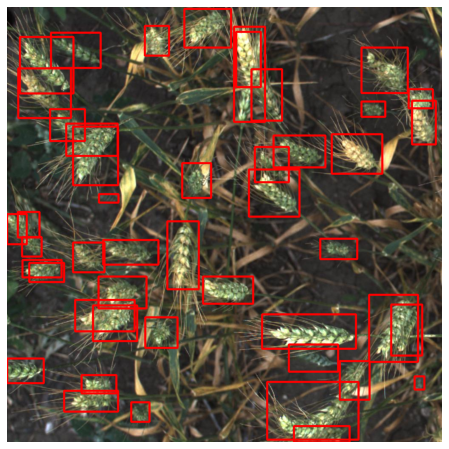

In [0]:
boxes = target['boxes'].cpu().numpy().astype(np.int32)
sample = image.permute(1, 2, 0).cpu().numpy().astype(np.float32)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                 (box[0], box[1]),
                 (box[2], box[3]),
                 (255, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)
plt.show()

In [0]:
# torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [0]:
def get_instance_objectdetection_model(num_classes, path_weight):
    create_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
    
    in_features = create_model.roi_heads.box_predictor.cls_score.in_features
    
    create_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    create_model.load_state_dict(torch.load(path_weight, map_location=torch.device('cpu')))
    
    return create_model

In [0]:
path_weight = '../input/fasterrcnn/fasterrcnn_resnet50_fpn_best.pth'

In [0]:
num_classes = 2
model = get_instance_objectdetection_model(num_classes, path_weight)

In [0]:
torch.cuda.empty_cache()

In [0]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [0]:
mode = 'training'

In [0]:
if mode == 'training':
    model.train()
    model.to(device)
    
    num_epochs = 10
    
    itr = 1
    
    for epoch in range(num_epochs):
        loss_sum = 0
        num_iterations = 0
        for images, targets, image_ids in train_dataloader:
            
            images = list(image.to(device, dtype=torch.float) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            
            loss_sum = loss_sum + loss_value
            num_iterations = num_iterations + 1
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            if itr % 5 == 0:
                print(f'Iteration #{itr} loss: {loss_value}')
                
            itr += 1
            
        if lr_scheduler is not None:
            lr_scheduler.step()
            
        if num_iterations > 0:
            loss_avg_value = loss_sum / num_iterations
            
        print('Epoch' + '#' + str(epoch) + ' loss: ' + str(loss_avg_value))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Iteration #5 loss: 0.6814626455307007
Iteration #10 loss: 0.5828604698181152
Iteration #15 loss: 0.7403721809387207
Iteration #20 loss: 0.7122113704681396
Iteration #25 loss: 0.5971168875694275
Iteration #30 loss: 0.6294126510620117
Iteration #35 loss: 0.6169599890708923
Iteration #40 loss: 0.5955994129180908
Iteration #45 loss: 0.7605549097061157
Iteration #50 loss: 0.7358750104904175
Iteration #55 loss: 0.6948848962783813
Iteration #60 loss: 0.677800178527832
Iteration #65 loss: 0.6283469796180725
Iteration #70 loss: 0.7173845171928406
Iteration #75 loss: 0.6717333793640137
Iteration #80 loss: 0.5049164295196533
Iteration #85 loss: 0.3552010655403137
Iteration #90 loss: 0.8018386960029602
Iteration #95 loss: 0.6142297387123108
Iteration #100 loss: 0.5495378971099854
Iteration #105 loss: 0.530943751335144
Iteration #110 loss: 0.4564065635204315
Iteration #115 loss: 0.5380802154541016
Iteration #120 loss: 0.5165903568267822
Iteration #125 loss: 0.5421091318130493
Iteration #130 loss: 0

In [0]:
torch.save(model.state_dict(), './customtrained_fasterrcnn_resnet50_fpn.pth')

In [0]:
path_trained_weight = '../input/fasterrcnn/customtrained_fasterrcnn_resnet50_fpn.pth'
num_classes = 2
trained_model = get_instance_objectdetection_model(num_classes, path_trained_weight)

In [0]:
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

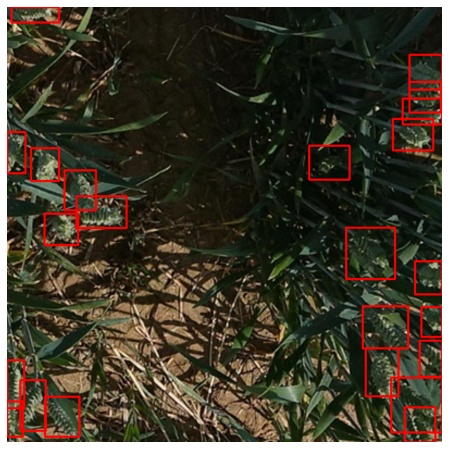

In [0]:
trained_model.eval()
trained_model.to(device)

images, targets, image_ids = next(iter(val_dataloader))

images = list(image.to(device, dtype=torch.float) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1, 2, 0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
  cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 3)
  ax.set_axis_off()
  ax.imshow(sample)

In [0]:
class GlobalWheatDetectionTestDataset(torch.utils.data.Dataset):
  def __init__(self, input_df, input_dir, transforms=None):
    self.df = input_df
    self.list_images = list(self.df['image_id'].unique())
    self.image_dir = input_dir
    self.transforms = transforms

  def __getitem__(self, idx):
    img_id = self.list_images[idx]

    img = cv2.imread(self.image_dir + '/' + img_id + '.jpg')
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_scaled = img / 255.
    img_final = img_scaled

    if self.transforms is not None:
      img_final = self.transforms(img_final)

    return img_final, img_id

  def __len__(self):
    return len(self.df['image_id'].unique())

In [0]:
df_test = pd.read_csv('../input/global-wheat-detection/sample_submission.csv')

In [0]:
df_test.head()

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50


In [0]:
test_dataset = GlobalWheatDetectionTestDataset(df_test, test_dir, get_transform())

In [0]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size = 8,
    shuffle = False,
    num_workers = 2,
    collate_fn = collate_fn
)

In [0]:
detection_threshold = 0.45

In [0]:
def format_prediction_string(boxes, scores): ## Define the formate for storing prediction results
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [0]:
device = torch.device('cuda')

In [0]:
results = []
trained_model.eval()
images = []
outputs = []
for images_, image_idx in test_dataloader:
  images = list(image.to(device, dtype=torch.float) for image in images_)
  outputs = trained_model(images)

  for i, image in enumerate(images):
    boxes = outputs[i]['boxes'].data.cpu().numpy()
    scores = outputs[i]['scores'].data.cpu().numpy()

    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    scores = scores[scores >= detection_threshold]

    image_id = image_idx[i]

    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

    result = {
        'image_id': image_id,
        'PredictionString': format_prediction_string(boxes, scores)
    }

    results.append(result)
  
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


,image_id,PredictionString
0,aac893a91,0.9716 615 914 76 98 0.9613 588 773 95 117 0.9...
1,51f1be19e,0.9787 761 881 152 106 0.9721 503 458 210 111 ...
2,f5a1f0358,0.9831 286 460 162 95 0.9767 141 753 158 114 0...
3,796707dd7,0.9791 895 333 109 86 0.9730 669 455 113 120 0...
4,51b3e36ab,0.9976 3 423 101 320 0.9969 234 641 94 154 0.9...


In [0]:
test_df.to_csv('submission.csv', index=False)

In [0]:
sample = images[1].permute(1, 2, 0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


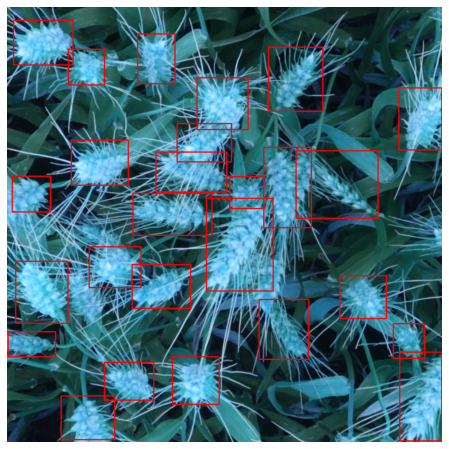

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

for box in boxes:
  cv2.rectangle(sample, 
                (box[0], box[1]),
                (box[2], box[3]),
                (220, 0, 0), 2)
  
ax.set_axis_off()
ax.imshow(sample)